In [20]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import cv2
import pickle
from tqdm import tqdm
from models.efficient_net import ImprovedEfficientNet
from config import Config


def load_data():
    """Load validation data"""
    try:
        # Load bounding box data
        df = pd.read_csv('lung_bbox.csv')
        bbox_dict = {row['Image']: [
            max(0.0, row['Xmin']), max(0.0, row['Ymin']),
            min(1.0, row['Xmax']), min(1.0, row['Ymax'])
        ] for _, row in df.iterrows()}

        # Load pickle files
        with open('process_input/splitall/series_list_train.pickle', 'rb') as f:
            series_list = pickle.load(f)
        with open('process_input/splitall/series_dict.pickle', 'rb') as f:
            series_dict = pickle.load(f)
        with open('process_input/splitall/image_dict.pickle', 'rb') as f:
            image_dict = pickle.load(f)
            
        # Get validation series (last 20% of series)
        num_val = int(len(series_list) * 0.2)
        series_list_valid = series_list[-num_val:]
        
        print(f"Loaded {len(series_list_valid)} validation series")
        return bbox_dict, series_list_valid, series_dict, image_dict
    
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None, None, None, None

def create_validation_data(series_list_valid, series_dict):
    """Create validation dataset"""
    image_list_valid = []
    for series_id in series_list_valid:
        sorted_image_list = series_dict[series_id]['sorted_image_list']
        num_image = len(sorted_image_list)
        selected_idx = [
            int(0.2*num_image), int(0.3*num_image),
            int(0.4*num_image), int(0.5*num_image)
        ]
        image_list_valid.extend([sorted_image_list[i] for i in selected_idx])
    return image_list_valid

def load_model(checkpoint_path):
    """Load model with checkpoint handling"""
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
        
        model = ImprovedEfficientNet('efficientnet-b3')
        checkpoint = torch.load(checkpoint_path, map_location=device)
        
        # Handle different checkpoint formats
        if isinstance(checkpoint, dict):
            state_dict = checkpoint.get('model_state_dict', checkpoint)
        else:
            state_dict = checkpoint
            
        # Clean state dict
        cleaned_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
        model.load_state_dict(cleaned_dict, strict=False)
        
        model = model.to(device)
        model.eval()
        return model, device
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None, None

def compute_iou(bbox1, bbox2):
    """Compute IoU between two bounding boxes"""
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    bbox1_area = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    bbox2_area = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
    
    union = bbox1_area + bbox2_area - intersection
    return intersection / (union + 1e-6)

def preprocess_image(image):
    """Preprocess image for model input"""
    # Normalize
    image = (image - image.min()) / (image.max() - image.min())
    image = cv2.resize(image, (Config.image_size, Config.image_size))
    
    # Convert to 3 channels
    image_3ch = np.stack([image] * 3, axis=2)
    return image_3ch

def evaluate_model(model, device, image_list_valid, image_dict, bbox_dict):
    """Evaluate model performance"""
    results = []
    
    with torch.no_grad():
        for image_id in tqdm(image_list_valid):
            try:
                # Load image
                study_id = image_dict[image_id]['series_id'].split('_')[0]
                series_id = image_dict[image_id]['series_id'].split('_')[1]
                dcm_path = os.path.join(Config.train_data_dir, study_id, series_id, f"{image_id}.dcm")
                
                # Read DICOM
                data = pydicom.dcmread(dcm_path)
                image = data.pixel_array.astype(np.float32)
                image = image * data.RescaleSlope + data.RescaleIntercept
                
                # Preprocess
                processed_image = preprocess_image(image)
                
                # Convert to tensor
                x = torch.from_numpy(processed_image.transpose(2, 0, 1)).float()
                x = x.unsqueeze(0).to(device)
                
                # Get prediction
                pred_bbox = model(x).cpu().numpy()[0]
                gt_bbox = bbox_dict[image_id]
                iou = compute_iou(pred_bbox, gt_bbox)
                
                results.append({
                    'image_id': image_id,
                    'pred_bbox': pred_bbox,
                    'gt_bbox': gt_bbox,
                    'iou': iou,
                    'image': processed_image[:, :, 0]  # Store single channel
                })
                
            except Exception as e:
                print(f"Error processing {image_id}: {str(e)}")
                continue
                
    return results

def visualize_results(results, num_samples=10):
    """Visualize model predictions and save plots"""
    if not results:
        print("No results to visualize!")
        return
        
    os.makedirs('results', exist_ok=True)
    
    # 1. Plot IoU Distribution
    plt.figure(figsize=(12, 6))
    ious = [r['iou'] for r in results]
    
    plt.hist(ious, bins=30, color='blue', alpha=0.7)
    plt.axvline(np.mean(ious), color='red', linestyle='--', 
                label=f'Mean IoU: {np.mean(ious):.3f}')
    plt.title('Distribution of IoU Scores', fontsize=14)
    plt.xlabel('IoU Score', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save IoU distribution
    plt.savefig('results/iou_distribution.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    # 2. Plot Sample Predictions
    num_samples = min(num_samples, len(results))
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 5*num_samples))
    
    if num_samples == 1:
        axes = [axes]
    
    for idx, (ax, result) in enumerate(zip(axes, results[:num_samples])):
        # Display image
        ax.imshow(result['image'], cmap='gray')
        
        h, w = result['image'].shape
        
        # Ground truth box (green)
        gt_box = result['gt_bbox']
        rect_gt = plt.Rectangle(
            (gt_box[0]*w, gt_box[1]*h),
            (gt_box[2]-gt_box[0])*w,
            (gt_box[3]-gt_box[1])*h,
            fill=False, color='green', linewidth=2, label='Ground Truth'
        )
        ax.add_patch(rect_gt)
        
        # Predicted box (red)
        pred_box = np.clip(result['pred_bbox'], 0, 1)
        rect_pred = plt.Rectangle(
            (pred_box[0]*w, pred_box[1]*h),
            (pred_box[2]-pred_box[0])*w,
            (pred_box[3]-pred_box[1])*h,
            fill=False, color='red', linewidth=2, label='Prediction'
        )
        ax.add_patch(rect_pred)
        
        ax.set_title(f"Image: {result['image_id']}\nIoU: {result['iou']:.3f}", 
                    fontsize=12, pad=10)
        ax.legend(loc='upper right')
        ax.axis('off')
    
    plt.tight_layout()
    # Save predictions visualization
    plt.savefig('results/sample_predictions.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    # 3. Generate Summary Plot
    plt.figure(figsize=(10, 6))
    summary_data = {
        'Mean IoU': np.mean(ious),
        'Median IoU': np.median(ious),
        'Min IoU': np.min(ious),
        'Max IoU': np.max(ious),
        'Std IoU': np.std(ious)
    }
    
    plt.bar(summary_data.keys(), summary_data.values(), color='skyblue')
    plt.title('IoU Statistics Summary', fontsize=14)
    plt.ylabel('IoU Score', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (key, value) in enumerate(summary_data.items()):
        plt.text(i, value, f'{value:.3f}', ha='center', va='bottom')
    
    plt.savefig('results/summary_statistics.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    # Print statistics
    print("\nEvaluation Statistics:")
    print("-" * 50)
    print(f"Number of images evaluated: {len(results)}")
    print(f"Mean IoU: {np.mean(ious):.3f}")
    print(f"Median IoU: {np.median(ious):.3f}")
    print(f"Min IoU: {np.min(ious):.3f}")
    print(f"Max IoU: {np.max(ious):.3f}")
    print(f"Std IoU: {np.std(ious):.3f}")
    print("-" * 50)
    print(f"\nPlots saved in results/ directory:")
    print("- iou_distribution.png")
    print("- sample_predictions.png")
    print("- summary_statistics.png")

def save_results(results):
    """Save evaluation results to CSV"""
    results_df = pd.DataFrame([
        {
            'image_id': r['image_id'],
            'iou': r['iou'],
            'pred_x1': r['pred_bbox'][0],
            'pred_y1': r['pred_bbox'][1],
            'pred_x2': r['pred_bbox'][2],
            'pred_y2': r['pred_bbox'][3],
            'gt_x1': r['gt_bbox'][0],
            'gt_y1': r['gt_bbox'][1],
            'gt_x2': r['gt_bbox'][2],
            'gt_y2': r['gt_bbox'][3]
        }
        for r in results
    ])
    
    os.makedirs('results', exist_ok=True)
    results_df.to_csv('results/evaluation_results.csv', index=False)
    print("Results saved to results/evaluation_results.csv")

def main():
    # Load data
    bbox_dict, series_list_valid, series_dict, image_dict = load_data()
    if None in (bbox_dict, series_list_valid, series_dict, image_dict):
        return
    
    # Create validation dataset
    image_list_valid = create_validation_data(series_list_valid, series_dict)
    print(f"Number of validation images: {len(image_list_valid)}")
    
    # Load model
    model, device = load_model('weights/model_epoch_40.pth')
    if model is None:
        return
    
    # Evaluate model
    results = evaluate_model(model, device, image_list_valid, image_dict, bbox_dict)
    
    # Visualize and save results
    visualize_results(results)
    save_results(results)

if __name__ == "__main__":
    main()

Loaded 1164 validation series
Number of validation images: 4656
Using device: cuda
Loaded pretrained weights for efficientnet-b3


/tmp/ipykernel_3473940/1821138511.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
100%|██████████| 4656/46


Evaluation Statistics:
--------------------------------------------------
Number of images evaluated: 4656
Mean IoU: 0.933
Median IoU: 0.941
Min IoU: 0.059
Max IoU: 0.996
Std IoU: 0.056
--------------------------------------------------

Plots saved in results/ directory:
- iou_distribution.png
- sample_predictions.png
- summary_statistics.png
Results saved to results/evaluation_results.csv


/tmp/ipykernel_1238423/3022204329.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('weights/model_epoch_40.pth', map_location=device)


Loaded pretrained weights for efficientnet-b3


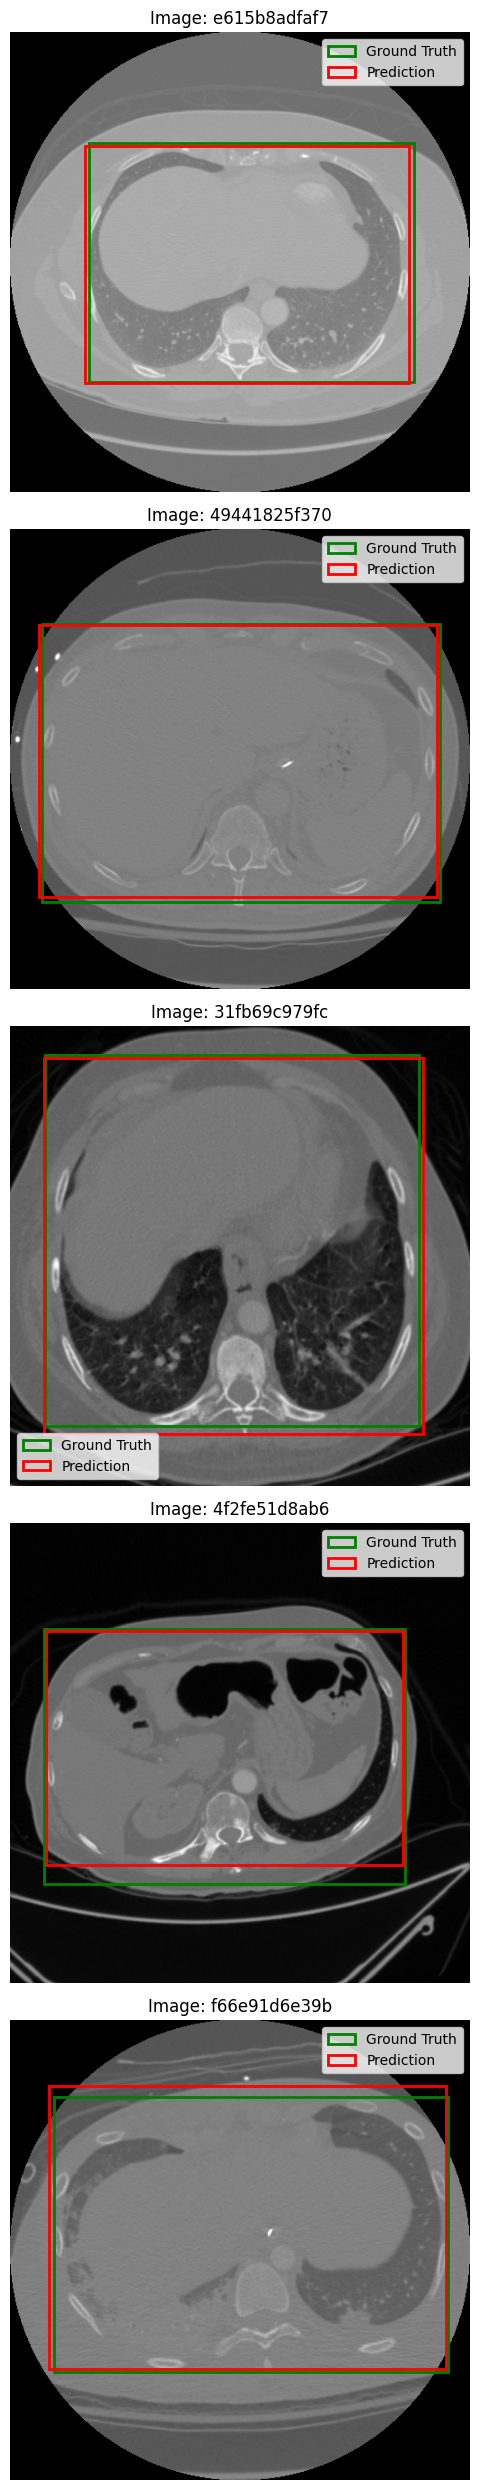

In [15]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import cv2
import pickle
from tqdm import tqdm
import albumentations as A
from models.efficient_net import ImprovedEfficientNet
from config import Config

def load_data_and_model():
    """Load data and model"""
    # Load bounding box data
    df = pd.read_csv('lung_bbox.csv')
    bbox_dict = {row['Image']: [
        max(0.0, row['Xmin']), max(0.0, row['Ymin']),
        min(1.0, row['Xmax']), min(1.0, row['Ymax'])
    ] for _, row in df.iterrows()}

    # Load pickle files
    with open('process_input/splitall/series_list_train.pickle', 'rb') as f:
        series_list = pickle.load(f)
    with open('process_input/splitall/series_dict.pickle', 'rb') as f:
        series_dict = pickle.load(f)
    with open('process_input/splitall/image_dict.pickle', 'rb') as f:
        image_dict = pickle.load(f)
    
    # Load model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load checkpoint
    checkpoint = torch.load('weights/model_epoch_40.pth', map_location=device)
    
    # Create model instance
    model = ImprovedEfficientNet('efficientnet-b3')
    
    # Extract model state dict
    if 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
        
    # Clean state dict keys
    cleaned_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            k = k[7:]  # Remove 'module.' prefix
        cleaned_state_dict[k] = v
    
    # Load state dict with strict=False
    model.load_state_dict(cleaned_state_dict, strict=False)
    model = model.to(device)
    model.eval()
    
    return bbox_dict, series_list, series_dict, image_dict, model, device

def get_sample_images(series_dict, image_dict, bbox_dict, num_samples=5):
    """Get random sample images from dataset"""
    samples = []
    series_ids = list(series_dict.keys())
    
    for _ in range(num_samples):
        # Get random series
        series_id = np.random.choice(series_ids)
        sorted_images = series_dict[series_id]['sorted_image_list']
        
        # Get random image from series
        image_id = np.random.choice(sorted_images)
        
        # Get image path
        study_id = image_dict[image_id]['series_id'].split('_')[0]
        series_num = image_dict[image_id]['series_id'].split('_')[1]
        dcm_path = f'{Config.train_data_dir}/train/{study_id}/{series_num}/{image_id}.dcm'
        
        # Load image
        data = pydicom.dcmread(dcm_path)
        image = data.pixel_array.astype(np.float32)
        image = image * data.RescaleSlope + data.RescaleIntercept
        
        # Normalize image
        image = (image - image.min()) / (image.max() - image.min())
        
        samples.append({
            'image_id': image_id,
            'image': image,
            'bbox': bbox_dict[image_id]
        })
    
    return samples

def visualize_samples(samples, model, device):
    """Visualize samples with predictions"""
    num_samples = len(samples)
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 5*num_samples))
    if num_samples == 1:
        axes = [axes]
    
    for idx, sample in enumerate(samples):
        image = sample['image']
        bbox = sample['bbox']
        
        # Preprocess for model
        processed_image = cv2.resize(image, (512, 512))
        x = np.stack([processed_image] * 3, axis=2)
        x = torch.from_numpy(x.transpose(2, 0, 1)).float()
        x = x.unsqueeze(0).to(device)
        
        # Get prediction
        with torch.no_grad():
            pred_bbox = model(x).cpu().numpy()[0]
        
        # Plot
        ax = axes[idx]
        ax.imshow(processed_image, cmap='gray')
        
        h, w = processed_image.shape
        # Ground truth box (green)
        ax.add_patch(plt.Rectangle(
            (bbox[0]*w, bbox[1]*h),
            (bbox[2]-bbox[0])*w,
            (bbox[3]-bbox[1])*h,
            fill=False, color='g', linewidth=2, label='Ground Truth'
        ))
        
        # Prediction box (red)
        ax.add_patch(plt.Rectangle(
            (pred_bbox[0]*w, pred_bbox[1]*h),
            (pred_bbox[2]-pred_bbox[0])*w,
            (pred_bbox[3]-pred_bbox[1])*h,
            fill=False, color='r', linewidth=2, label='Prediction'
        ))
        
        ax.set_title(f"Image: {sample['image_id']}")
        ax.legend()
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Main execution
# Load data and model
bbox_dict, series_list, series_dict, image_dict, model, device = load_data_and_model()

# Get and visualize samples
num_samples = 5
samples = get_sample_images(series_dict, image_dict, bbox_dict, num_samples)
visualize_samples(samples, model, device)

Loaded 1164 validation series
Number of validation images: 4656
Loaded pretrained weights for efficientnet-b3


/tmp/ipykernel_1976989/3583211366.py:355: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('hybrid_model_output/checkpoints/checkpoint_epoch_15.pth')
10

Results saved to results/evaluation_results.csv


100%|██████████| 4656/4656 [06:35<00:00, 11.77it/s]


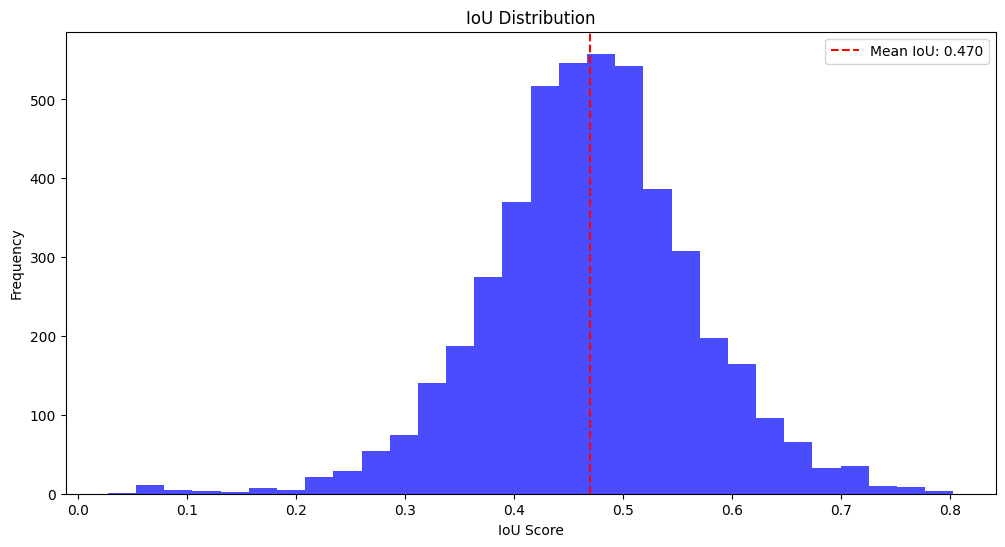


Evaluation Statistics:
Mean IoU: 0.470
Median IoU: 0.471
Min IoU: 0.027
Max IoU: 0.803


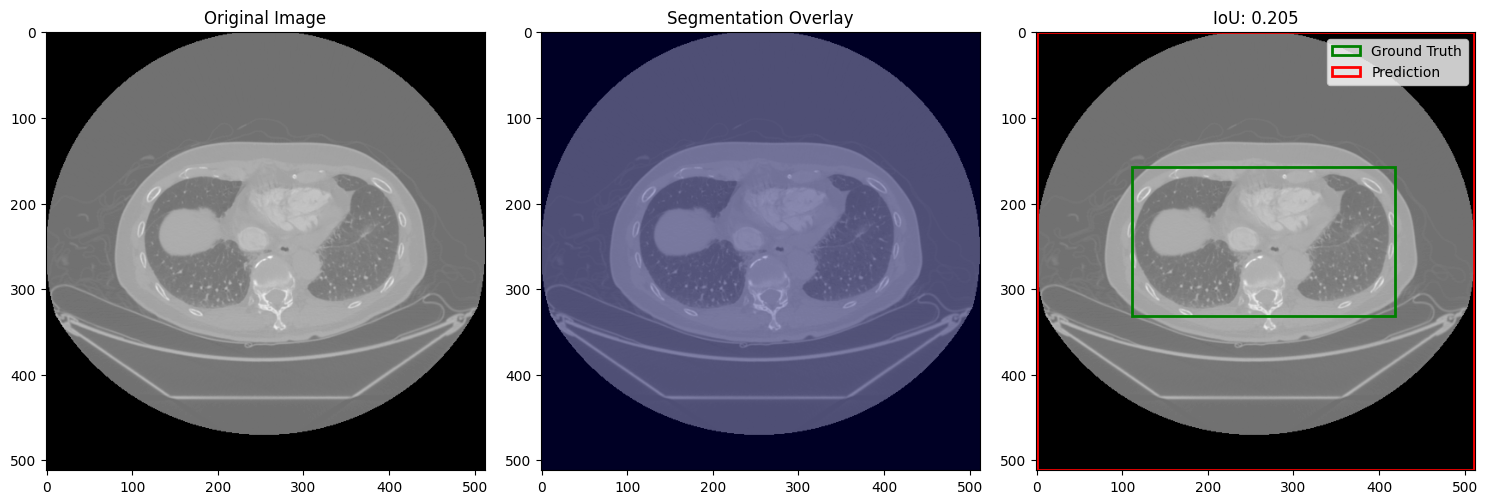

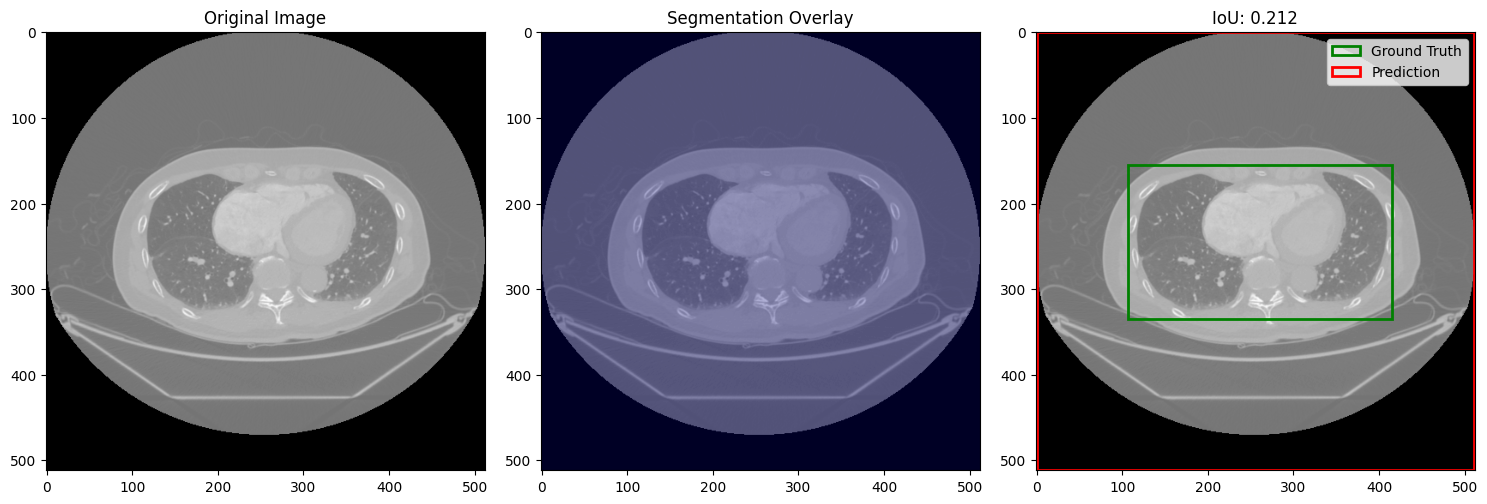

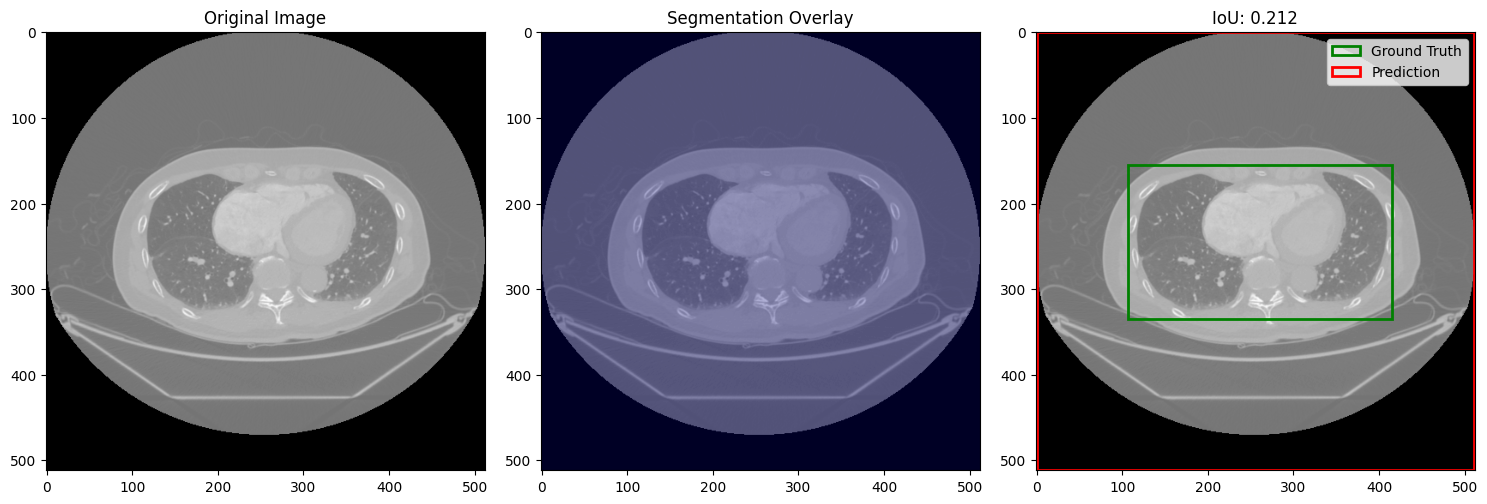

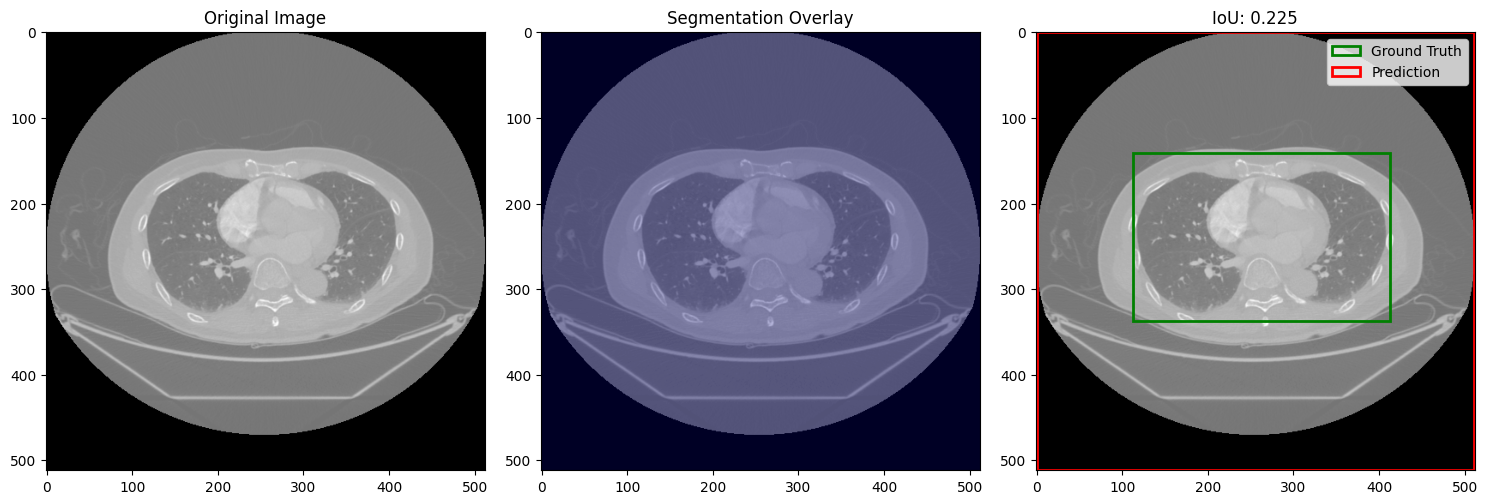

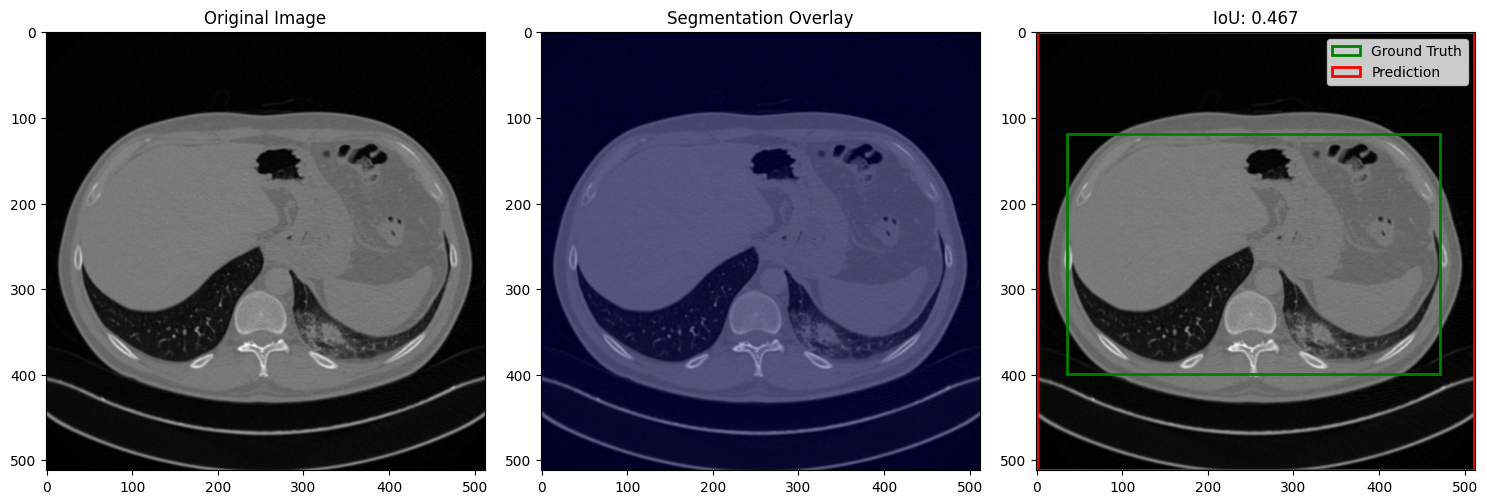

In [24]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import cv2
import pickle
from tqdm import tqdm
from models.unet import UNet
from config import Config
from models.hybrid_model import HybridModel
def load_data():
    """Load validation data"""
    try:
        # Load bounding box data
        df = pd.read_csv('lung_bbox.csv')
        bbox_dict = {row['Image']: [
            max(0.0, row['Xmin']), max(0.0, row['Ymin']),
            min(1.0, row['Xmax']), min(1.0, row['Ymax'])
        ] for _, row in df.iterrows()}

        # Load pickle files
        with open('process_input/splitall/series_list_train.pickle', 'rb') as f:
            series_list = pickle.load(f)
        with open('process_input/splitall/series_dict.pickle', 'rb') as f:
            series_dict = pickle.load(f)
        with open('process_input/splitall/image_dict.pickle', 'rb') as f:
            image_dict = pickle.load(f)
            
        # Get validation series (last 20% of series)
        num_val = int(len(series_list) * 0.2)
        series_list_valid = series_list[-num_val:]
        
        print(f"Loaded {len(series_list_valid)} validation series")
        return bbox_dict, series_list_valid, series_dict, image_dict
    
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None, None, None, None

def compute_iou(bbox1, bbox2):
    """Compute IoU between two bounding boxes"""
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    bbox1_area = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    bbox2_area = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
    
    union = bbox1_area + bbox2_area - intersection
    return intersection / (union + 1e-6)

def process_mask(pred_mask):
    """Process segmentation mask for visualization"""
    # Threshold mask
    binary_mask = (pred_mask > 0.5).astype(np.float32)
    
    # Add morphological operations
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    return mask
    
def evaluate_model(model, device, image_list_valid, image_dict, bbox_dict):
   results = []
   with torch.no_grad():
       for image_id in tqdm(image_list_valid):
           try:
               # Load image
               study_id = image_dict[image_id]['series_id'].split('_')[0]
               series_id = image_dict[image_id]['series_id'].split('_')[1]
               dcm_path = os.path.join(Config.train_data_dir, study_id, series_id, f"{image_id}.dcm")
               
               data = pydicom.dcmread(dcm_path)
               image = data.pixel_array.astype(np.float32)
               image = image * data.RescaleSlope + data.RescaleIntercept
               
               processed_image = preprocess_image(image)
               x = torch.from_numpy(processed_image.transpose(2, 0, 1)).float()
               x = x.unsqueeze(0).to(device)
               
               pred_bbox, pred_mask = model(x)
               pred_bbox = pred_bbox.cpu().numpy()[0]
               pred_mask = pred_mask.cpu().numpy()[0, 0]
               processed_mask = process_mask(pred_mask)
               
               gt_bbox = bbox_dict[image_id]
               iou = compute_iou(pred_bbox, gt_bbox)
               
               results.append({
                   'image_id': image_id,
                   'pred_bbox': pred_bbox,
                   'pred_mask': processed_mask,
                   'gt_bbox': gt_bbox,
                   'iou': iou,
                   'image': processed_image[:, :, 0]
               })
               
           except Exception as e:
               print(f"Error processing {image_id}: {str(e)}")
               continue
               
   return results

def create_validation_data(series_list_valid, series_dict):
    """Create validation dataset"""
    image_list_valid = []
    for series_id in series_list_valid:
        sorted_image_list = series_dict[series_id]['sorted_image_list']
        num_image = len(sorted_image_list)
        selected_idx = [
            int(0.2*num_image), int(0.3*num_image),
            int(0.4*num_image), int(0.5*num_image)
        ]
        image_list_valid.extend([sorted_image_list[i] for i in selected_idx])
    return image_list_valid
    
def evaluate_unet(model, device, image_list_valid, image_dict, bbox_dict):
    results = []
    with torch.no_grad():
        for image_id in tqdm(image_list_valid):
            try:
                study_id = image_dict[image_id]['series_id'].split('_')[0]
                series_id = image_dict[image_id]['series_id'].split('_')[1]
                dcm_path = os.path.join(Config.train_data_dir, study_id, series_id, f"{image_id}.dcm")
                
                data = pydicom.dcmread(dcm_path)
                image = data.pixel_array.astype(np.float32)
                image = image * data.RescaleSlope + data.RescaleIntercept
                
                # Preprocess same as HybridModel
                processed_image = preprocess_image(image)
                x = torch.from_numpy(processed_image.transpose(2, 0, 1)).float()
                x = x.unsqueeze(0).to(device)
                
                # Get predictions
                pred_bbox, pred_mask = model(x)
                pred_mask = pred_mask.squeeze().cpu().numpy()
                pred_mask = (pred_mask > 0.5).astype(np.float32)
                
                # Convert mask to bbox
                pred_bbox = mask_to_bbox(pred_mask)
                gt_bbox = bbox_dict[image_id]
                iou = compute_iou(pred_bbox, gt_bbox)
                
                results.append({
                    'image_id': image_id,
                    'pred_bbox': pred_bbox,
                    'gt_bbox': gt_bbox,
                    'iou': iou,
                    'image': processed_image[:, :, 0],
                    'pred_mask': pred_mask
                })
            except Exception as e:
                print(f"Error processing {image_id}: {str(e)}")
                continue
    return results

def mask_to_bbox(mask):
    """Convert segmentation mask to bbox coordinates"""
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    if not np.any(rows) or not np.any(cols):
        return [0, 0, 1, 1]
    
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    
    # Normalize coordinates
    h, w = mask.shape
    return [cmin/w, rmin/h, cmax/w, rmax/h]

def visualize_unet_results(results, num_samples=10):
    """Extended visualization including segmentation masks"""
    if not results:
        print("No results to visualize!")
        return
        
    os.makedirs('results/unet', exist_ok=True)
    
    # IoU Distribution
    plt.figure(figsize=(12, 6))
    ious = [r['iou'] for r in results]
    plt.hist(ious, bins=30, color='blue', alpha=0.7)
    plt.axvline(np.mean(ious), color='red', linestyle='--', 
                label=f'Mean IoU: {np.mean(ious):.3f}')
    plt.title('U-Net IoU Distribution')
    plt.xlabel('IoU Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig('results/unet/iou_distribution.png')
    plt.close()
    
    # Sample predictions with masks
    num_samples = min(num_samples, len(results))
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i, result in enumerate(results[:num_samples]):
        # Original image
        axes[i,0].imshow(result['image'], cmap='gray')
        axes[i,0].set_title('Original Image')
        
        # Segmentation mask
        axes[i,1].imshow(result['pred_mask'], cmap='jet')
        axes[i,1].set_title('Segmentation Mask')
        
        # Bounding boxes
        axes[i,2].imshow(result['image'], cmap='gray')
        h, w = result['image'].shape
        
        # Ground truth box
        gt_box = result['gt_bbox']
        rect_gt = plt.Rectangle(
            (gt_box[0]*w, gt_box[1]*h),
            (gt_box[2]-gt_box[0])*w,
            (gt_box[3]-gt_box[1])*h,
            fill=False, color='green', linewidth=2, label='Ground Truth'
        )
        axes[i,2].add_patch(rect_gt)
        
        # Predicted box
        pred_box = result['pred_bbox']
        rect_pred = plt.Rectangle(
            (pred_box[0]*w, pred_box[1]*h),
            (pred_box[2]-pred_box[0])*w,
            (pred_box[3]-pred_box[1])*h,
            fill=False, color='red', linewidth=2, label='Prediction'
        )
        axes[i,2].add_patch(rect_pred)
        axes[i,2].set_title(f'IoU: {result["iou"]:.3f}')
        axes[i,2].legend()
    
    plt.tight_layout()
    plt.savefig('results/unet/sample_predictions.png')
    plt.close()

def preprocess_image(image):
    """Preprocess image for model input"""
    # Normalize
    image = (image - image.min()) / (image.max() - image.min())
    image = cv2.resize(image, (Config.image_size, Config.image_size))
    
    # Convert to 3 channels
    image_3ch = np.stack([image] * 3, axis=2)
    return image_3ch

def save_results(results):
    """Save evaluation results to CSV"""
    results_df = pd.DataFrame([
        {
            'image_id': r['image_id'],
            'iou': r['iou'],
            'pred_x1': r['pred_bbox'][0],
            'pred_y1': r['pred_bbox'][1],
            'pred_x2': r['pred_bbox'][2],
            'pred_y2': r['pred_bbox'][3],
            'gt_x1': r['gt_bbox'][0],
            'gt_y1': r['gt_bbox'][1],
            'gt_x2': r['gt_bbox'][2],
            'gt_y2': r['gt_bbox'][3]
        }
        for r in results
    ])
    
    os.makedirs('results', exist_ok=True)
    results_df.to_csv('results/evaluation_results.csv', index=False)
    print("Results saved to results/evaluation_results.csv")
    
def visualize_notebook_results(results, num_samples=5):
    if not results:
        print("No results to visualize!")
        return
    
    # Plot IoU Distribution
    plt.figure(figsize=(12, 6))
    ious = [r['iou'] for r in results]
    plt.hist(ious, bins=30, color='blue', alpha=0.7)
    plt.axvline(np.mean(ious), color='red', linestyle='--', 
                label=f'Mean IoU: {np.mean(ious):.3f}')
    plt.title('IoU Distribution')
    plt.xlabel('IoU Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    # Print statistics
    print(f"\nEvaluation Statistics:")
    print(f"Mean IoU: {np.mean(ious):.3f}")
    print(f"Median IoU: {np.median(ious):.3f}")
    print(f"Min IoU: {np.min(ious):.3f}")
    print(f"Max IoU: {np.max(ious):.3f}")
    
    # Plot sample predictions
    num_samples = min(num_samples, len(results))
    for i, result in enumerate(results[:num_samples]):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original
        ax1.imshow(result['image'], cmap='gray')
        ax1.set_title('Original Image')
        
        ax2.imshow(result['image'], cmap='gray')
        mask_overlay = np.ma.masked_where(result['pred_mask'] == 0, result['pred_mask'])
        ax2.imshow(mask_overlay, cmap='jet', alpha=0.3)
        ax2.set_title('Segmentation Overlay')
        
        # Boxes
        ax3.imshow(result['image'], cmap='gray')
        h, w = result['image'].shape
        
        # Ground truth box
        gt_box = result['gt_bbox']
        rect_gt = plt.Rectangle(
            (gt_box[0]*w, gt_box[1]*h),
            (gt_box[2]-gt_box[0])*w,
            (gt_box[3]-gt_box[1])*h,
            fill=False, color='green', linewidth=2, label='Ground Truth'
        )
        ax3.add_patch(rect_gt)
        
        # Prediction box
        pred_box = result['pred_bbox']
        rect_pred = plt.Rectangle(
            (pred_box[0]*w, pred_box[1]*h),
            (pred_box[2]-pred_box[0])*w,
            (pred_box[3]-pred_box[1])*h,
            fill=False, color='red', linewidth=2, label='Prediction'
        )
        ax3.add_patch(rect_pred)
        ax3.set_title(f'IoU: {result["iou"]:.3f}')
        ax3.legend()
        
        plt.tight_layout()
        plt.show()

def main():
   # Load data
   bbox_dict, series_list_valid, series_dict, image_dict = load_data()
   if None in (bbox_dict, series_list_valid, series_dict, image_dict):
       return
   
   # Create validation dataset
   image_list_valid = create_validation_data(series_list_valid, series_dict)
   print(f"Number of validation images: {len(image_list_valid)}")
   
   # Load model
   device = torch.device('cuda')
   model = HybridModel().to(device)
   
   # Load checkpoint
   checkpoint = torch.load('hybrid_model_output/checkpoints/checkpoint_epoch_15.pth')
   state_dict = checkpoint.get('model_state_dict', checkpoint)
   cleaned_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
   model.load_state_dict(cleaned_dict, strict=False)
   model.eval()
   
   # Evaluate model with all required parameters
   results = evaluate_model(model, device, image_list_valid, image_dict, bbox_dict)
   # Visualize and save
   visualize_unet_results(results)
   save_results(results)
    
   results2 = evaluate_unet(model, device, image_list_valid, image_dict, bbox_dict)
   visualize_notebook_results(results2)

if __name__ == "__main__":
    main()

In [25]:
# Import necessary libraries and modules first
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_notebook_results(results, num_samples=5):
    if not results:
        print("No results to visualize!")
        return
    
    # Plot IoU Distribution
    plt.figure(figsize=(12, 6))
    ious = [r['iou'] for r in results]
    plt.hist(ious, bins=30, color='blue', alpha=0.7)
    plt.axvline(np.mean(ious), color='red', linestyle='--', 
                label=f'Mean IoU: {np.mean(ious):.3f}')
    plt.title('IoU Distribution')
    plt.xlabel('IoU Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    # Print statistics
    print(f"\nEvaluation Statistics:")
    print(f"Mean IoU: {np.mean(ious):.3f}")
    print(f"Median IoU: {np.median(ious):.3f}")
    print(f"Min IoU: {np.min(ious):.3f}")
    print(f"Max IoU: {np.max(ious):.3f}")
    
    # Plot sample predictions
    num_samples = min(num_samples, len(results))
    for i, result in enumerate(results[:num_samples]):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original
        ax1.imshow(result['image'], cmap='gray')
        ax1.set_title('Original Image')
        
        # Segmentation
        ax2.imshow(result['pred_mask'], cmap='jet')
        ax2.set_title('Segmentation Mask')
        
        # Boxes
        ax3.imshow(result['image'], cmap='gray')
        h, w = result['image'].shape
        
        # Ground truth box
        gt_box = result['gt_bbox']
        rect_gt = plt.Rectangle(
            (gt_box[0]*w, gt_box[1]*h),
            (gt_box[2]-gt_box[0])*w,
            (gt_box[3]-gt_box[1])*h,
            fill=False, color='green', linewidth=2, label='Ground Truth'
        )
        ax3.add_patch(rect_gt)
        
        # Prediction box
        pred_box = result['pred_bbox']
        rect_pred = plt.Rectangle(
            (pred_box[0]*w, pred_box[1]*h),
            (pred_box[2]-pred_box[0])*w,
            (pred_box[3]-pred_box[1])*h,
            fill=False, color='red', linewidth=2, label='Prediction'
        )
        ax3.add_patch(rect_pred)
        ax3.set_title(f'IoU: {result["iou"]:.3f}')
        ax3.legend()
        
        plt.tight_layout()
        plt.show()

# Run evaluation
results = evaluate_model(model, device, image_list_valid, image_dict, bbox_dict)
visualize_notebook_results(results)

NameError: name 'model' is not defined

Loaded 1164 validation series
Loaded pretrained weights for efficientnet-b3


/tmp/ipykernel_1976989/2931863808.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('hybrid_model_output/checkpoints/checkpoint_epoch_15.pth')
100

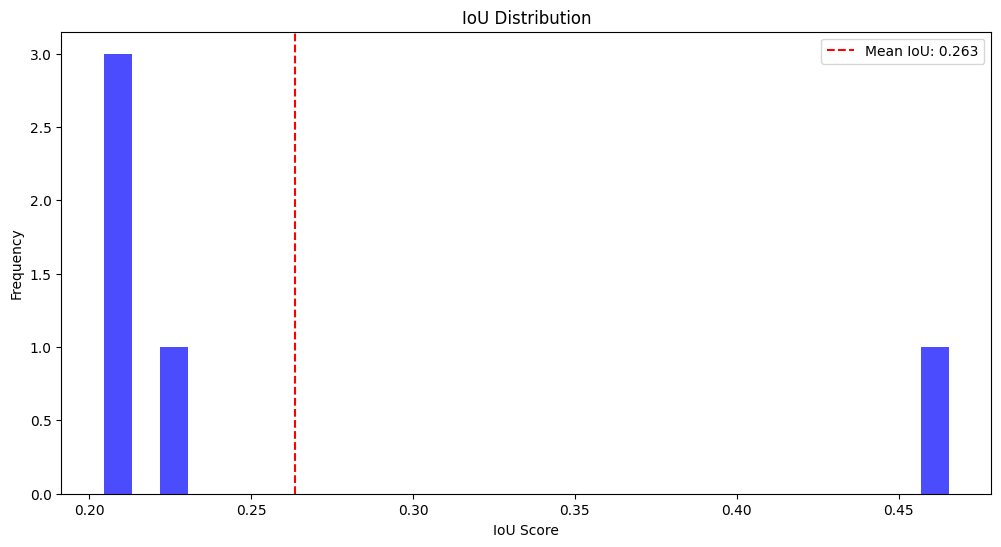


Evaluation Statistics:
Mean IoU: 0.263
Median IoU: 0.211
Min IoU: 0.204
Max IoU: 0.466


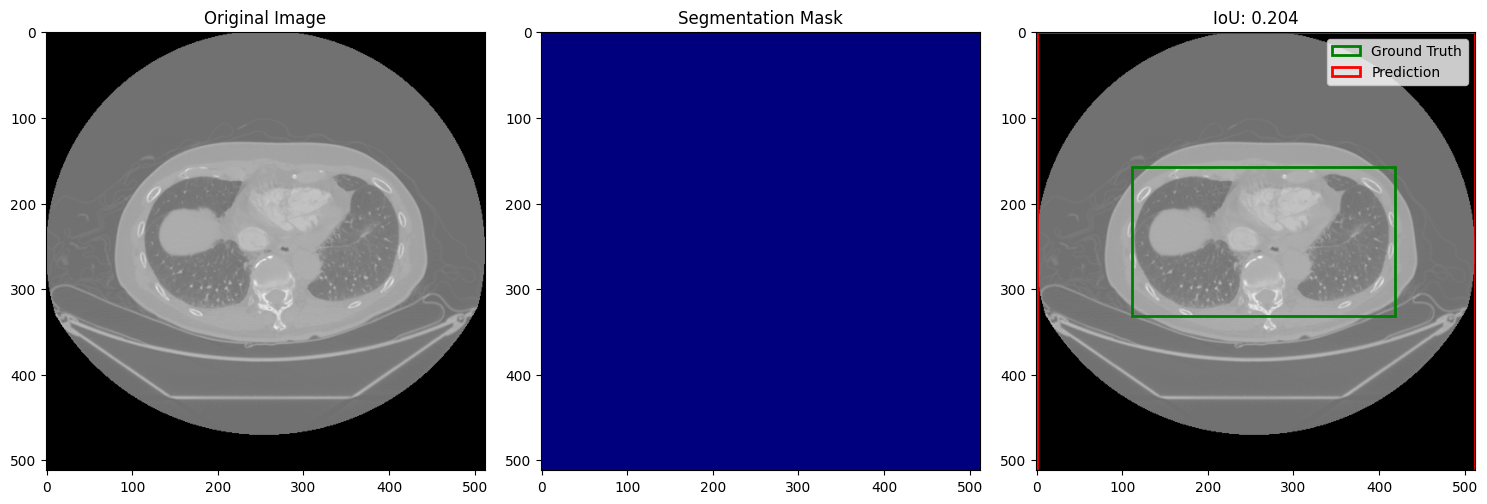

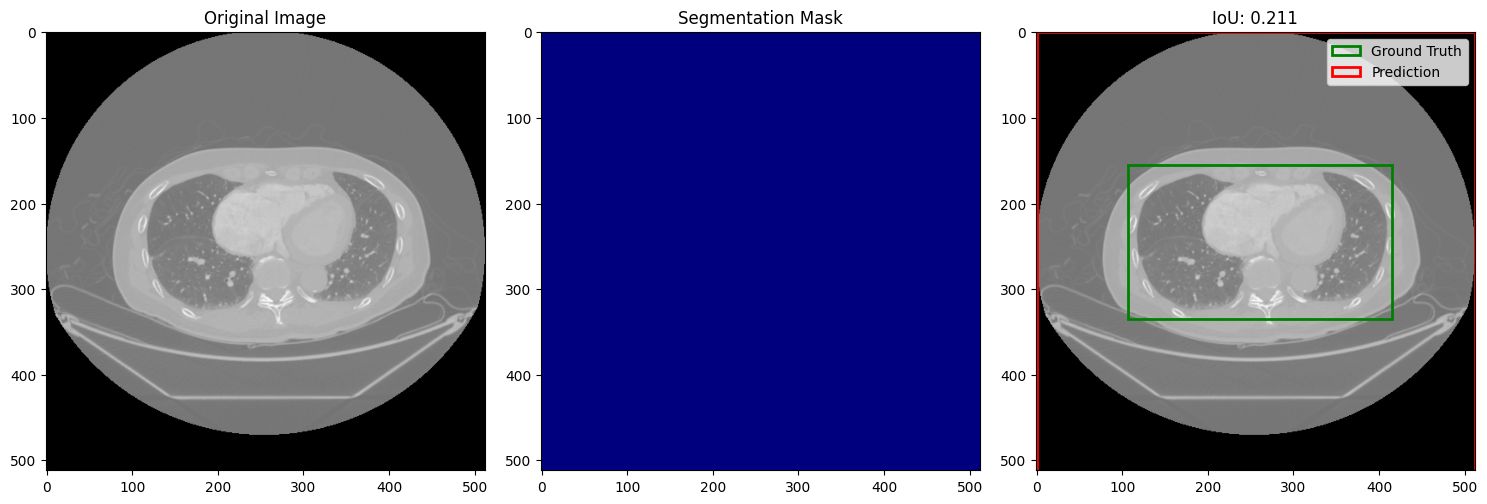

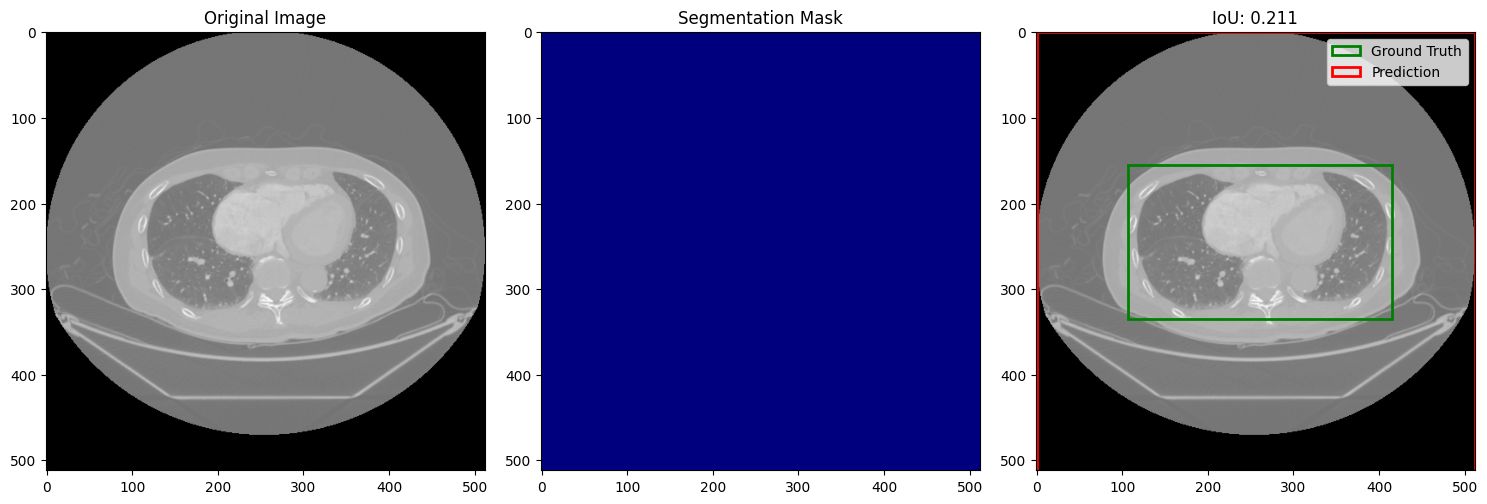

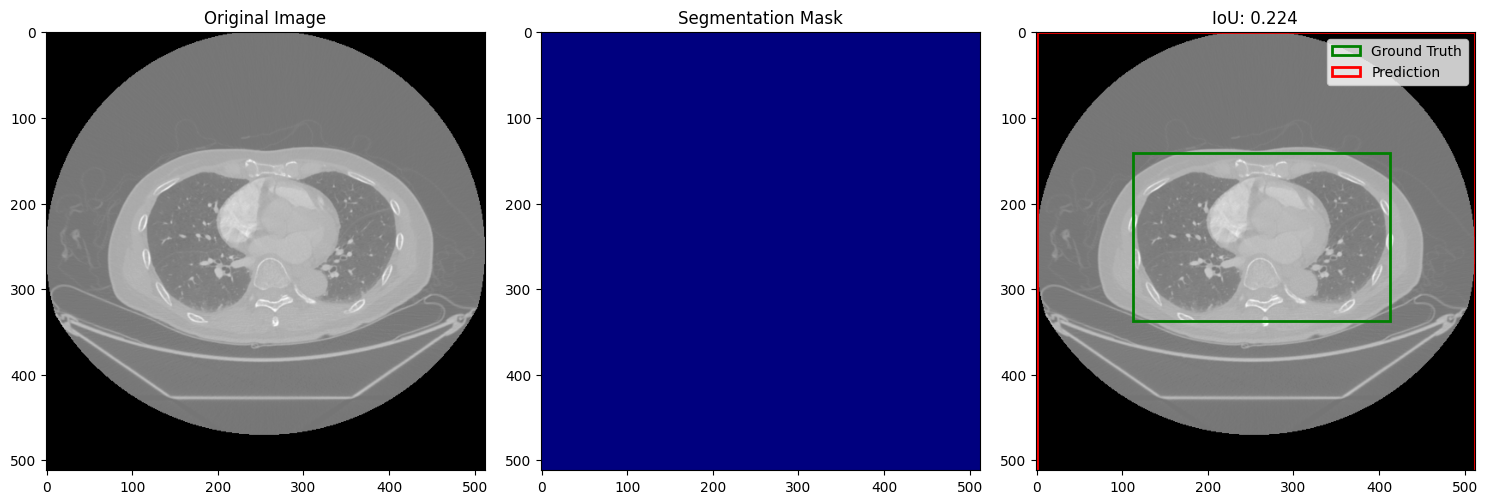

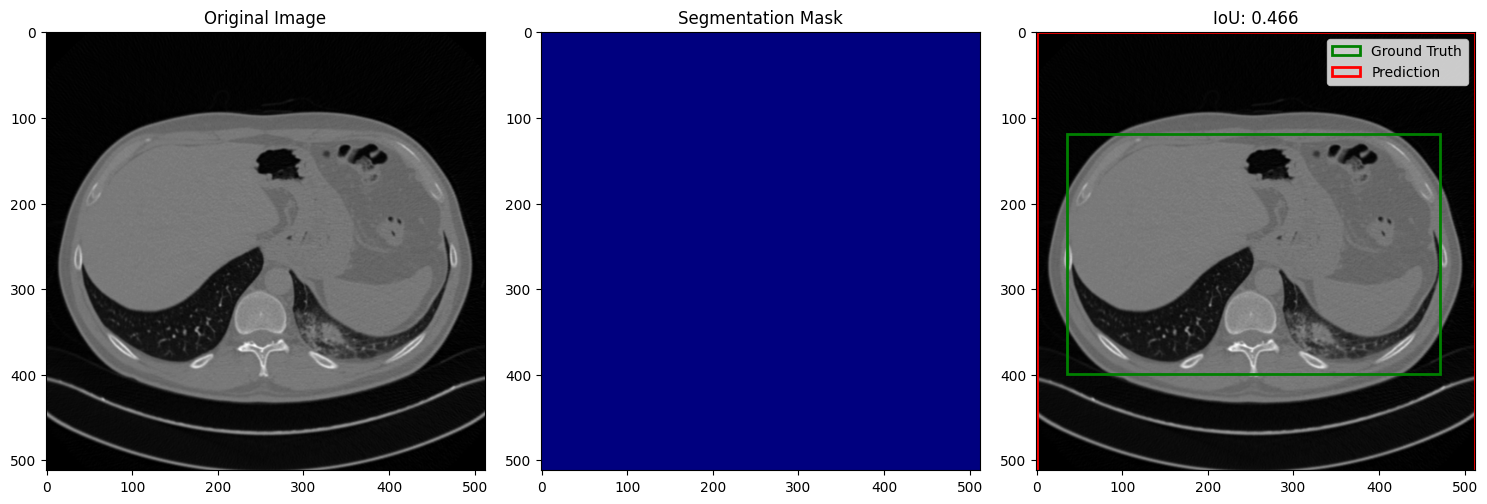

In [26]:
def quick_model_check():
    # Load data
    bbox_dict, series_list_valid, series_dict, image_dict = load_data()
    if None in (bbox_dict, series_list_valid, series_dict, image_dict):
        return
    
    # Get validation images
    image_list_valid = create_validation_data(series_list_valid, series_dict)[:5]  # Test with 5 images
    
    # Setup model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = HybridModel().to(device)
    checkpoint = torch.load('hybrid_model_output/checkpoints/checkpoint_epoch_15.pth')
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    model.load_state_dict({k.replace('module.', ''): v for k, v in state_dict.items()}, strict=False)
    model.eval()
    
    # Evaluate
    results = evaluate_model(model, device, image_list_valid, image_dict, bbox_dict)
    visualize_notebook_results(results)

if __name__ == "__main__":
    quick_model_check()